In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

In [3]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2020-04-27 19:45:22--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  4.22MB/s    in 0.2s    

2020-04-27 19:45:22 (4.22 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [4]:

!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [5]:
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# **Join Ratings with Movies**

In [7]:
ratings = ratings.merge(movies,on ='movieId').drop(['genres','timestamp'],axis=1)
ratings.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [8]:
user_enc = LabelEncoder()
ratings['userSeq'] = user_enc.fit_transform(ratings['userId'].values)
item_enc = LabelEncoder()
ratings['movieSeq'] = item_enc.fit_transform(ratings['movieId'].values)

ratings.head()

,userId,movieId,rating,title,userSeq,movieSeq
0,1,1,4.0,Toy Story (1995),0,0
1,5,1,4.0,Toy Story (1995),4,0
2,7,1,4.5,Toy Story (1995),6,0
3,15,1,2.5,Toy Story (1995),14,0
4,17,1,4.5,Toy Story (1995),16,0


In [9]:
train_unused, test = train_test_split(ratings, test_size=0.20, random_state=0)
train  = ratings
numUsers = len(train.userSeq.unique())
numMovies = len(train.movieSeq.unique())
print(numUsers,numMovies)
print(len(train),len(test))

610 9724
100836 20168


In [11]:
numFeatures = 50
dropout = 0.0

user_input = Input(shape=(1,))
user_emb = Embedding(numUsers,numFeatures)(user_input)
flat_user = Flatten()(user_emb)
user_dropout = Dropout(dropout)(flat_user)

movie_input = Input(shape=(1,))
movie_emb = Embedding(numMovies,numFeatures)(movie_input)
flat_movie = Flatten()(movie_emb)
movie_dropout = Dropout(dropout)(flat_movie)

dotProduct = Dot(axes=1)([user_dropout,movie_dropout])

user_bias = Embedding(numUsers,1)(user_input)
movie_bias = Embedding(numMovies,1)(movie_input)
sum = Add() ([dotProduct, user_bias,movie_bias])
flat_sum = Flatten()(sum)
output = Dropout(dropout)(flat_sum)

model = Model([user_input,movie_input],output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        30500       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 50)        486200      input_4[0][0]                    
______________________________________________________________________________________________

Epoch 1/10
3152/3152 [==============================] - 23s 7ms/step - loss: 6.2096 - val_loss: 1.4571
Epoch 2/10
3152/3152 [==============================] - 22s 7ms/step - loss: 1.1374 - val_loss: 0.7899
Epoch 3/10
3152/3152 [==============================] - 21s 7ms/step - loss: 0.7985 - val_loss: 0.6327
Epoch 4/10
3152/3152 [==============================] - 21s 7ms/step - loss: 0.6590 - val_loss: 0.5249
Epoch 5/10
3152/3152 [==============================] - 20s 6ms/step - loss: 0.5537 - val_loss: 0.4473
Epoch 6/10
3152/3152 [==============================] - 20s 6ms/step - loss: 0.4661 - val_loss: 0.3662
Epoch 7/10
3152/3152 [==============================] - 20s 6ms/step - loss: 0.3870 - val_loss: 0.2992
Epoch 8/10
3152/3152 [==============================] - 20s 6ms/step - loss: 0.3199 - val_loss: 0.2428
Epoch 9/10
3152/3152 [==============================] - 19s 6ms/step - loss: 0.2635 - val_loss: 0.1949
Epoch 10/10
3152/3152 [==============================] - 20s 6ms/step - l

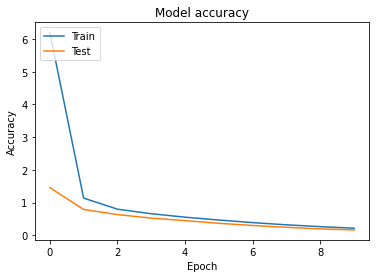

In [13]:
model.compile(loss='mean_squared_error', optimizer=Adam())
history = model.fit([train.userSeq, train.movieSeq], train.rating,
                    batch_size=32, epochs=10, verbose=1,
                    validation_data=([test.userSeq, test.movieSeq], test.rating))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
userNumber = 0

uniqueMovies = ratings.drop_duplicates(subset=['movieSeq'])

movie_vector = uniqueMovies.movieSeq.values
user_vector = np.ones((len(uniqueMovies),)) * userNumber
predictions = model.predict([user_vector, movie_vector])
pSeries = pd.Series([a[0] for a in predictions])
predictedDF = uniqueMovies.copy()
predictedDF['Predictions'] = pSeries

predictedDF.sort_values(by='Predictions', ascending=False).head(10)

,userId,movieId,rating,title,userSeq,movieSeq,Predictions
5770,1,1025,5.0,"Sword in the Stone, The (1963)",0,783,6.208174
2755,1,362,5.0,"Jungle Book, The (1994)",0,320,5.622069
6127,1,1080,5.0,Monty Python's Life of Brian (1979),0,819,5.603706
4830,1,648,3.0,Mission: Impossible (1996),0,546,5.497403
4121,1,592,4.0,Batman (1989),0,509,5.464499
3188,1,480,4.0,Jurassic Park (1993),0,418,5.328232
2316,1,349,4.0,Clear and Present Danger (1994),0,307,5.268976
776,1,70,3.0,From Dusk Till Dawn (1996),0,62,5.210256
1135,1,157,5.0,Canadian Bacon (1995),0,130,5.205760
6457,1,1097,5.0,E.T. the Extra-Terrestrial (1982),0,835,5.059707


# **Error Analysis**

In [17]:
oneUser = predictedDF[predictedDF.userSeq == userNumber].copy()
oneUser['Error'] = (oneUser.rating - oneUser.Predictions)**2
oneUser.sort_values(by='Error',ascending=False).head(5)

,userId,movieId,rating,title,userSeq,movieSeq,Predictions,Error
4649,1,608,5.0,Fargo (1996),0,520,0.920014,16.646288
6216,1,1089,5.0,Reservoir Dogs (1992),0,827,1.651428,11.212937
6641,1,1136,5.0,Monty Python and the Holy Grail (1975),0,862,1.666136,11.114650
7753,1,1213,5.0,Goodfellas (1990),0,913,1.720146,10.757443
5795,1,1029,5.0,Dumbo (1941),0,786,1.763833,10.472775


In [18]:
ratings[ratings.movieSeq==520].sort_values(by = 'rating',ascending=True)

,userId,movieId,rating,title,userSeq,movieSeq
4827,607,608,2.0,Fargo (1996),606,520
4672,78,608,2.0,Fargo (1996),77,520
4810,546,608,2.0,Fargo (1996),545,520
4669,71,608,2.0,Fargo (1996),70,520
4812,554,608,2.0,Fargo (1996),553,520
...,...,...,...,...,...,...
4725,251,608,5.0,Fargo (1996),250,520
4718,221,608,5.0,Fargo (1996),220,520
4717,220,608,5.0,Fargo (1996),219,520
4754,324,608,5.0,Fargo (1996),323,520
